In [94]:
%matplotlib inline
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, MetaData
import sqlalchemy
from sqlalchemy import Integer, String, Float
from sqlalchemy import Column,Integer,Sequence, String, Boolean
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
import psycopg2
import numpy as np
import matplotlib.pyplot as pp
import pandas as pd
import seaborn
import scipy.stats as stats
import pylab as pl
import folium
import datetime as dt
import random as rnd



In [8]:
result = pd.read_excel('/Users/ryan/Desktop/may12_portaldata.xlsx', encoding= 'utf-8-sig')

result['hh_size_hhinfo'] = pd.to_numeric(result['hh_size_hhinfo'], errors='coerce')

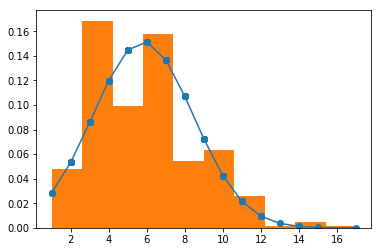

In [9]:
h = sorted(result['hh_size_hhinfo'].dropna())  #sorted

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h,normed=True)      #use this to draw histogram of your data

pl.show()  

In [83]:
a = result.gps_location_end.str.split(' ').dropna()
b = pd.DataFrame((item for item in a), columns = ['lat','long','alt','acc'])
b['lat'] = pd.to_numeric(b['lat'], errors='coerce')
b['long'] = pd.to_numeric(b['long'], errors='coerce')
b['ref'] = result['refusal']
b['comp'] = result['incomplete']

In [100]:
lat = b['lat'].values
lon = b['long'].values
colors = {1 : 'red', 0 : 'blue'}

lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

map_osm = folium.Map(location=[20.5937, 78.9629],zoom_start=5)
b.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["long"]], 
                                              radius=1,color=colors[row['comp']])
                                             .add_to(map_osm), axis=1)

style_statement = '<style>.leaflet-control{color:#00FF00}</style>'
map_osm.get_root().header.add_child(folium.Element(style_statement))
map_osm
